# Testing GCM's perfomance while handling discrete variables

In [420]:
from dowhy import gcm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

### Creating the GCM

#### Setting the DAG

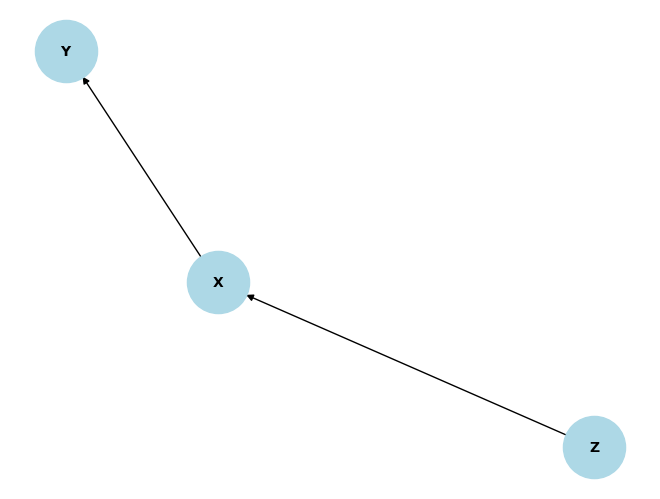

In [421]:
causal_graph = nx.DiGraph([
    ('X', 'Y'),
    ('Z', 'X')
])

causal_model = gcm.StructuralCausalModel(causal_graph)

nx.draw(causal_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

#### Generating data

$Z$ is a discrete variable with probabilities:
$$ P(Z=0) = 0.3 $$
$$ P(Z=1) = 0.4 $$
$$ P(Z=2) = 0.3 $$

$X$ is a binary variable that depends on $Z$ with probabilities:
$$ P(X = 1| Z = 0) = 0.2 $$
$$ P(X = 1| Z = 1) = 0.5 $$
$$ P(X = 1| Z = 2) = 0.8 $$

$Y$ is a binary variable that depends directly on $X$ with probabilities:
$$ P(Y=1|X=0) = 0.3 $$
$$ P(Y=1|X=1) = 0.7 $$

In [422]:
# Number of samples to generate
n_samples = 1000

# Generate Z as a discrete variable (e.g., values 0, 1, 2)
Z_values = np.array([0, 1, 2])
Z_probs = np.array([0.3, 0.4, 0.3])  # Probabilities for Z=0,1,2
Z = np.random.choice(Z_values, size=n_samples, p=Z_probs)

# Generate X conditional on Z
# X is binary: 0 or 1
# Define P(X=1 | Z)
P_X_given_Z = np.array([0.2, 0.5, 0.8])  # For Z=0,1,2 respectively

X = np.zeros(n_samples, dtype=int)
for idx, z in enumerate(Z):
    p_x_given_z = P_X_given_Z[z]
    X[idx] = np.random.binomial(1, p_x_given_z)

# Generate Y conditional on X
# Y is binary: 0 or 1
# Define P(Y=1 | X)
P_Y_given_X = np.array([0.3, 0.7])  # For X=0,1 respectively

Y = np.zeros(n_samples, dtype=int)
for idx, x in enumerate(X):
    p_y_given_x = P_Y_given_X[x]
    Y[idx] = np.random.binomial(1, p_y_given_x)

# Create a DataFrame to store the data
data = pd.DataFrame({
    'Z': Z,
    'X': X,
    'Y': Y
})
data = data.astype(str)

# Display the first few rows of the data
data.head()


,Z,X,Y
0,0,0,0
1,2,1,0
2,1,0,1
3,1,0,1
4,0,1,1


#### Setting the causal mechanisms

In this example, we will set $Z$'s causal mechanism to be an Empirical Distribution, since it's an exogenous variable, and $X$'s and $Y$'s to be a ClassifierFCM, since it's they are binary variables. 

In [423]:
causal_model.set_causal_mechanism('Z', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('X', gcm.ClassifierFCM(gcm.ml.SklearnClassificationModel(RandomForestClassifier())))
causal_model.set_causal_mechanism('Y', gcm.ClassifierFCM(gcm.ml.SklearnClassificationModel(RandomForestClassifier())))

It's also important to note that we DoWhy supports using models from the scikit-learn library. In this case, we will be using their Random Forest Classifier.

#### Fitting the model and generating new data

In [424]:
gcm.fit(causal_model, data)
generated_data = gcm.draw_samples(causal_model, num_samples=1000)
generated_data.head()

Fitting causal mechanism of node Z: 100%|██████████| 3/3 [00:00<00:00, 18.73it/s]


,Z,X,Y
0,0,0,0
1,1,0,1
2,1,0,0
3,0,0,1
4,0,0,1


### Calculating the ACE

In [425]:
gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'X': lambda x: '1'},
                         interventions_reference={'X': lambda x: '0'},
                         num_samples_to_draw=1000)

### Estimating confidence intervals (Confidence level = 0.95)

In [426]:
gcm.confidence_intervals(lambda: gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'X': lambda x: '1'},
                         interventions_reference={'X': lambda x: '0'},
                         num_samples_to_draw=1000))

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:00<00:00, 43.28it/s]


(array([0.38778328]), array([[0.34895, 0.42225]]))

The ACE can be calculated by doing:
$$ ACE = E[Y=1|do(X=1)] - E[Y=1|do(X=0)] = P(Y=1|X=1) - P(Y=1|X=0) = 0.7 - 0.3 = 0.4

Considering we found a value close to 0.4, it's possible to say the results are satisfactory.